<a href="https://colab.research.google.com/github/tripatheea/auto/blob/main/autoencoder_from_the_ground_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow.keras import regularizers
import tensorflow.keras.initializers

from scipy.fft import fft, ifft, fftfreq


!pip install corner

import corner

tfd = tfp.distributions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
sampling_freq = 100
T_duration = 1 

N = sampling_freq * T_duration

In [3]:
def generate_signal(sampling_freq=100, T_duration=1, noiseamp=0.000, hamp=5.0, f_sig=8.0):
    
    
    t = np.linspace(0.0, T_duration, sampling_freq * T_duration, endpoint=False)
    Nsample = len(t)
    noise = noiseamp * np.random.normal(0, scale = 1, size = Nsample)
    signal = hamp * np.sin(2 * np.pi * (f_sig * t))

    data = signal + noise
    
    return data

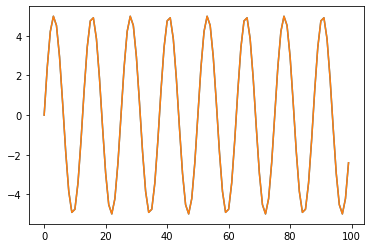

In [4]:
y = generate_signal()

plt.plot(y)
plt.plot(generate_signal())

In [5]:
N_data_points = 100

In [6]:
f_s = np.linspace(15, 20, N_data_points)

np.random.shuffle(f_s)

In [7]:
y_s = []
x_s = []
for f in f_s:
    y = generate_signal(sampling_freq=sampling_freq, T_duration=T_duration, noiseamp=0.000000, hamp=100.0, f_sig=f)
    xf = fftfreq(N, 1 / sampling_freq)[:N//2]
    
    fft_y = fft(y)
    
    re = np.array([np.real(a) for a in fft_y])
    im = np.array([np.imag(a) for a in fft_y])
    
    re = (re - np.mean(re)) / np.std(re)
    im = (im - np.mean(im)) / np.std(im)
    
    y_fft = [[f, r, i] for f, r, i in zip(xf, re, im)]
    y_s.append(y_fft)
    x_s.append([f])

x_s, y_s = np.array(x_s), np.array(y_s)

y_s = y_s.astype(np.float32)
x_s = x_s.astype(np.float32)

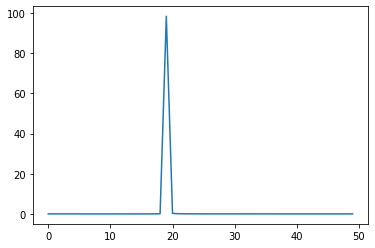

In [8]:
freq = y_s[0][:,0]
mag = y_s[0][:,1] ** 2 + y_s[0][:,2] ** 2

plt.plot(freq, mag)

In [9]:
split = 0.7

cutoff = int(split * len(x_s))

print(cutoff, len(x_s))

70 100


In [10]:
x_s = tf.convert_to_tensor(x_s, dtype=tf.float32)
y_s = tf.convert_to_tensor(y_s, dtype=tf.float32)

In [11]:
x_train, y_train = x_s[:cutoff], y_s[:cutoff]
x_test, y_test = x_s[cutoff:], y_s[cutoff:]

In [12]:
batch_size = 4

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(cutoff).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(cutoff).batch(batch_size)

In [14]:
len(train_dataset), len(test_dataset)

(18, 8)

In [15]:
for a in train_dataset.enumerate():
    print(a[0].shape, a[1][0].shape, a[1][1].shape)
    break

() (4, 1) (4, 50, 3)


In [16]:
tf.config.run_functions_eagerly(True)

In [17]:
def ramp_func(epoch,start,ramp_length, n_cycles):
    i = (epoch - start) / (2.0 * ramp_length)
    print(epoch,i)
    
    if i < 0:
        return 0.0
    if i >= n_cycles:
        return 1.0
    
    return min(1.0, 2.0 * np.remainder(i, 1.0))

optimizer = tf.keras.optimizers.Adam(1e-4)
initializer = tf.keras.initializers.GlorotUniform()

In [18]:
# This is the encoder that encodes x which is just the time-series in either time or frequency domain.


x_dim, n_channels = 4, 4
y_dim = 1
input_shape = (x_dim, n_channels)


z_dim = 3
n_modes = 2
x_modes = 1

assert z_dim > x_modes

r1_input_x = tf.keras.Input(shape=input_shape)

encoder_r1_x_first_part = tf.keras.layers.Conv1D(filters=1, kernel_size=2, strides=1)(r1_input_x) # Each filter is applied separately. So 3 filters would essentially produce 3 separate layers.
encoder_r1_x_first_part = tf.keras.layers.Flatten()(encoder_r1_x_first_part) # Flattens the matrix.

encoder_r1_x_second_part = tf.keras.layers.Dense(16)(encoder_r1_x_first_part)
encoder_r1_x = tf.keras.layers.Dense(2 * z_dim * n_modes + n_modes)(encoder_r1_x_second_part)
# a2 = a

In [19]:
x_encoder_model = tf.keras.Model(inputs=r1_input_x, outputs=encoder_r1_x)

x_encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 4)]            0         
                                                                 
 conv1d (Conv1D)             (None, 3, 1)              9         
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 16)                64        
                                                                 
 dense_1 (Dense)             (None, 14)                238       
                                                                 
Total params: 311
Trainable params: 311
Non-trainable params: 0
_________________________________________________________________


In [63]:
input_norm = np.random.normal(0, 1, (4, 4)).reshape((1, 4, 4))   # Input x is (4, 4)


x_input_norm = tf.convert_to_tensor(input_norm)

input_norm.shape, x_input_norm.shape

((1, 4, 4), TensorShape([1, 4, 4]))

In [21]:
x_encoder_model(x_input_norm)

<tf.Tensor: shape=(1, 14), dtype=float32, numpy=
array([[-0.42809886,  1.1861148 , -1.1884309 ,  1.6569933 ,  0.9835188 ,
         0.12392876, -0.961425  ,  0.5176296 , -0.6887892 , -1.215472  ,
         1.3028177 , -1.4342482 ,  0.95555407, -0.03998576]],
      dtype=float32)>

In [22]:
# Now build a network that encodes both x and y. In this scenario, we are going to encode both the "time-series" and the frequency of the source.



In [71]:
q_input_y = tf.keras.Input(shape=(y_dim))

# q_input_y_flattened = tf.keras.layers.Flatten()(q_input_y) # Not sure whether or not this is a good idea.

encoder_r1_y = tf.keras.layers.concatenate([encoder_r1_x_first_part, q_input_y])

encoder_r1_y = tf.keras.layers.Dense(2)(encoder_r1_y)

encoder_r1_y = tf.keras.layers.Dense(2 * z_dim)(encoder_r1_y)

In [72]:
y_encoder_model = tf.keras.Model(inputs=[r1_input_x, q_input_y], outputs=encoder_r1_y)

y_input_norm = tf.convert_to_tensor(np.random.normal(0, 1, (y_dim,))) # y input is (1, 1)

y_encoder_model([x_input_norm, y_input_norm])

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 0.9586711 ,  1.1119756 , -0.84627056,  1.0001388 , -0.77144414,
        -0.17072237]], dtype=float32)>

In [73]:
## So we have two encoders:
#  a) Encodes our "time-series"
#  b) Encodes our "time-series" and frequency (or any other predictor).
#  
# We can now force the network to learn how to build (b) from (a) such that (a) and (b) have the same latent representation.
# Then, when we have a new (a) (test data), we can endode it the same way we would if it were (b). Then, decode that to find the frequency.

In [74]:
# So let's build a decoder network.

In [96]:
r2_input_z = tf.keras.Input(shape=(z_dim))   # The input is our latent representation.

decoder_r1_z = tf.keras.layers.Flatten()(r2_input_z)  # Not sure if we need to flatten this or not.

# We're taking our x and z for decoding. So, the "time-series" and the label / frequency.
decoder_r1_z = tf.keras.layers.concatenate([encoder_r1_x_first_part, decoder_r1_z])
decoder_r1_z = tf.keras.layers.Dense(8)(decoder_r1_z)
decoder_r1_z = tf.keras.layers.Dense(2 * x_dim * x_modes + x_modes)(decoder_r1_z)

In [97]:
decoder_r2_z_model = tf.keras.Model(inputs=[r1_input_x, r2_input_z], outputs=decoder_r1_z)

In [98]:
z_input_norm =  tf.convert_to_tensor(np.random.normal(0, 1, (z_dim,)).reshape(-1, z_dim)) # z input is (z_dim, 1)

In [99]:
decoder_r2_z_model([x_input_norm, z_input_norm])

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[-1.1855365 , -0.86742693, -0.27236095, -0.1662738 , -0.4872437 ,
         1.4184157 ,  1.9721115 ,  0.58932465, -1.7211382 ]],
      dtype=float32)>

In [100]:
def encode_q_x_and_y(x=None, y=None):
  # return tf.split(y_encoder_model([x, y]), num_or_size_splits=[z_dim, z_dim], axis=1)
  ab = y_encoder_model([x, y])

  # print(ab.shape)
  
  return tf.split(ab, num_or_size_splits=[z_dim, z_dim], axis=1)

def encode_r1_x(x=None):
  mean, logvar, weight = tf.split(x_encoder_model(x), num_or_size_splits=[z_dim * n_modes, z_dim * n_modes, n_modes], axis=1)
  
  return tf.reshape(mean,[-1, n_modes, z_dim]), tf.reshape(logvar, [-1, n_modes, z_dim]), tf.reshape(weight, [-1, n_modes])

def decode_r2_x_and_z(x, z):
  mean, logvar, weight = tf.split(decoder_r2_z_model([x, z]), num_or_size_splits=[x_dim * x_modes, x_dim * x_modes, x_modes], axis=1)
  return tf.reshape(mean,[-1, x_modes, x_dim]), tf.reshape(logvar, [-1, x_modes, x_dim]), tf.reshape(weight, [-1, x_modes])

In [101]:
encode_q_x_and_y(x_input_norm, y_input_norm)

[<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.9586711 ,  1.1119756 , -0.84627056]], dtype=float32)>,
 <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 1.0001388 , -0.77144414, -0.17072237]], dtype=float32)>]

In [102]:
encode_r1_x(x_input_norm)

(<tf.Tensor: shape=(1, 2, 3), dtype=float32, numpy=
 array([[[-0.46004832, -1.1600399 ,  1.5285637 ],
         [-0.92791045, -0.57782525, -0.14804573]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2, 3), dtype=float32, numpy=
 array([[[ 0.23180005,  0.5905957 ,  0.5088981 ],
         [ 0.37839168, -0.74403876,  0.73883903]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.9549498,  0.5617389]], dtype=float32)>)

In [103]:
decode_r2_x_and_z(x_input_norm, z_input_norm)

(<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=
 array([[[-1.1855365 , -0.86742693, -0.27236095, -0.1662738 ]]],
       dtype=float32)>, <tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=
 array([[[-0.4872437 ,  1.4184157 ,  1.9721115 ,  0.58932465]]],
       dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.7211382]], dtype=float32)>)

In [104]:
# So we have a way to encode just x, or x and y.
# And a way to decode z and x to get y.

# x    => z
# x, y => z
# 
# x, z => y

In [105]:
# Let's take the time-series (x) and frequency (y) to find the latent distribution z.

In [106]:
z_latent = encode_q_x_and_y(x_input_norm, y_input_norm)

y_input_norm

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.59689445])>

In [107]:
z_latent

[<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.9586711 ,  1.1119756 , -0.84627056]], dtype=float32)>,
 <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 1.0001388 , -0.77144414, -0.17072237]], dtype=float32)>]

In [108]:
# Now, let's use the latent distribution z and x to reconstruct y.

In [109]:
decode_r2_x_and_z(x_input_norm, z_input_norm)

(<tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=
 array([[[-1.1855365 , -0.86742693, -0.27236095, -0.1662738 ]]],
       dtype=float32)>, <tf.Tensor: shape=(1, 1, 4), dtype=float32, numpy=
 array([[[-0.4872437 ,  1.4184157 ,  1.9721115 ,  0.58932465]]],
       dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.7211382]], dtype=float32)>)

In [110]:
class CVAE(tf.keras.Model):
  def __init__(self):
    super(CVAE, self).__init__()
    self.act = tf.keras.layers.LeakyReLU(alpha=0.1)
    self.reg = regularizers.l2(0.01)

  def encode_x(self, x):
    return encode_r1_x(x)

  def encode_x_and_y(self, x, y):
    return encode_q_x_and_y(x, y)

  def decode_x_and_z(self, x, z):
    return decode_r2_x_and_z

  def get_shape(self):
    print( x_encoder_model.summary() )
    print( y_encoder_model.summary() )
    print( decoder_r2_z_model.summary() )

In [111]:
def compute_loss(model, x, y, ramp=1.0, noiseampt=1.0):

  EPS = 1e-3

  x = x

  noiseamp = 1.0
  params = {}
  params['x_normscale'] = 1.0

  actual_y = y

  # Just create tf objects with noise amp and x norm scale.
  noiseamp = tf.cast(noiseamp, dtype=tf.float32)
  x_normscale = tf.cast(params['x_normscale'], dtype=tf.float32)

  # This is in the latent space z. z just from x.
  mean_r1_sample_z_from_x, logvar_r1_sample_z_from_x, logweight_r1_sample_z_from_x = encode_r1_x(x=x)
  scale_r1_sample_z_from_x = EPS + tf.sqrt(tf.exp(logvar_r1_sample_z_from_x))

  # Get latent representation z just from x.
  gm_r1_z_from_just_x = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r1_sample_z_from_x),
                        components_distribution=tfd.MultivariateNormalDiag(
                        loc=mean_r1_sample_z_from_x,
                        scale_diag=scale_r1_sample_z_from_x))
  
  # Now, use x and y to get the latent space z.

  # Latent space. z from x and y.
  mean_q_sample_z_from_x_and_y, logvar_q_sample_z_from_x_and_y = encode_q_x_and_y(x, y)
  scale_q_sample_z_from_x_and_y = EPS + tf.sqrt(tf.exp(logvar_q_sample_z_from_x_and_y))

  # Sample.
  mvn_q = tfp.distributions.MultivariateNormalDiag(
                            loc=mean_q_sample_z_from_x_and_y,
                            scale_diag=scale_q_sample_z_from_x_and_y)
      
  z_samp = mvn_q.sample()

  # Take the latent sample and y to reconstruct y. Pr[y | x, z]
  mean_r2_y_from_x_and_z, logvar_r2_y_from_x_and_z, logweight_r2_y_from_x_and_z = decode_r2_x_and_z(x=x, z=z_samp)
  scale_r2_y_from_x_and_z = EPS + tf.sqrt(tf.exp(logvar_r2_y_from_x_and_z))

  # This is a sample from y (our label).

  # Distribution for x. Pr[y | x, z]
  gm_r2_y_from_x_and_z = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logweight_r2_y_from_x_and_z),
                          components_distribution=tfd.MultivariateNormalDiag(
                          loc=mean_r2_y_from_x_and_z,
                          scale_diag=scale_r2_y_from_x_and_z))
  
  simple_cost_recon = -1.0*tf.reduce_mean(gm_r2_y_from_x_and_z.log_prob(tf.cast(y, tf.float32)))

  selfent_q = -1.0*tf.reduce_mean(mvn_q.entropy())
  log_r1_q = gm_r1_z_from_just_x.log_prob(z_samp)   # evaluate the log prob of z_sample for the distribution of z obtained from just x.

  # Calculate the K-L divergence.
  cost_KL = selfent_q - tf.reduce_mean(log_r1_q)

  return simple_cost_recon, cost_KL

In [143]:
train_loss_metric = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

@tf.function
def train_step(model, x, y, optimizer, ramp=1.0):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    
    ramp = 1.0
    
    with tf.GradientTape() as tape:
#         r_loss, kl_loss = compute_loss(model, x, y, ramp=ramp)
        r_loss, kl_loss = compute_loss(model, x, y, ramp)
        loss = r_loss + ramp * kl_loss
        
    gradients = tape.gradient(loss, model.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss_metric(loss)
    
    return r_loss, kl_loss

In [144]:
model = CVAE()

model.compile()

# model.build(x_input_norm.shape)

In [145]:
model.get_shape()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 4)]            0         
                                                                 
 conv1d (Conv1D)             (None, 3, 1)              9         
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 16)                64        
                                                                 
 dense_1 (Dense)             (None, 14)                238       
                                                                 
Total params: 311
Trainable params: 311
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_3"
_________________________________________

In [146]:
x_s = tf.reshape(x_input_norm, (*x_input_norm.shape, 1))
y_s = tf.reshape(y_input_norm, (*y_input_norm.shape, 1))

x_s.shape, y_s.shape, x_input_norm.shape, y_input_norm.shape

(TensorShape([1, 4, 4, 1]),
 TensorShape([1, 1]),
 TensorShape([1, 4, 4]),
 TensorShape([1]))

In [147]:
compute_loss(model, x_input_norm, y_input_norm)

(<tf.Tensor: shape=(), dtype=float32, numpy=5.960945>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1600523>)

In [148]:
multiple_x_s = np.random.normal(0, 1, (5, 1, 4, 4))   # Input x is (4, 4)
multiple_y_s = np.random.normal(0, 1, (5, 1))   # Input x is (4, 4)

multiple_x_s_tensor = tf.convert_to_tensor(multiple_x_s)
multiple_y_s_tensor = tf.convert_to_tensor(multiple_y_s)

multiple_x_s_tensor.shape, multiple_y_s_tensor.shape

(TensorShape([5, 1, 4, 4]), TensorShape([5, 1]))

In [149]:
for x, y in zip(multiple_x_s_tensor, multiple_y_s_tensor):
  compute_loss(model, x, y)

In [160]:
batch_size = 2

train_dataset = tf.data.Dataset.from_tensor_slices((multiple_x_s_tensor, multiple_y_s_tensor)).batch(batch_size)

In [174]:
epochs = 20

ramp_start = 1
ramp_length = 20
ramp_cycles = 1
train_loss = np.zeros((epochs, 2))
test_loss = np.zeros((epochs, 2))

ramp = tf.convert_to_tensor(ramp_func(epochs, ramp_start, ramp_length, ramp_cycles), dtype=tf.float32)

20 0.475


In [175]:
for epoch in range(1, epochs + 1):

  temp_train_r_loss, temp_train_kl_loss = 0.0, 0.0
  temp_test_r_loss, temp_test_kl_loss = 0.0, 0.0

  for step, (x, y) in enumerate(zip(multiple_x_s_tensor, multiple_y_s_tensor)):
    # print(step, x.shape, y.shape)

    temp_train_r_loss, temp_train_kl_loss = train_step(model, x, y, optimizer, ramp=ramp)
    
    train_loss[epoch - 1, 0] += temp_train_r_loss / len(multiple_x_s_tensor)
    train_loss[epoch - 1, 1] += temp_train_kl_loss / len(multiple_x_s_tensor)

  if epoch % 10 == 0:
    print("epoch = %d; train loss = %.4e, %.4e." % \
          (epoch, train_loss[epoch - 1, 0], train_loss[epoch - 1, 1]))

epoch = 10; train loss = 7.8094e-01, -2.0360e-01.
epoch = 10; train loss = 2.4584e+00, -4.5334e-02.
epoch = 10; train loss = 1.3426e+01, 6.1249e+00.
epoch = 10; train loss = 1.4732e+01, 7.9569e+00.
epoch = 10; train loss = 1.7079e+01, 1.0994e+01.
epoch = 20; train loss = 2.3116e+00, 6.7166e-02.
epoch = 20; train loss = 3.6338e+00, 1.4934e+00.
epoch = 20; train loss = 3.0737e+01, 8.3484e+00.
epoch = 20; train loss = 3.2050e+01, 1.0529e+01.
epoch = 20; train loss = 3.5836e+01, 1.3066e+01.


In [177]:
# train_loss

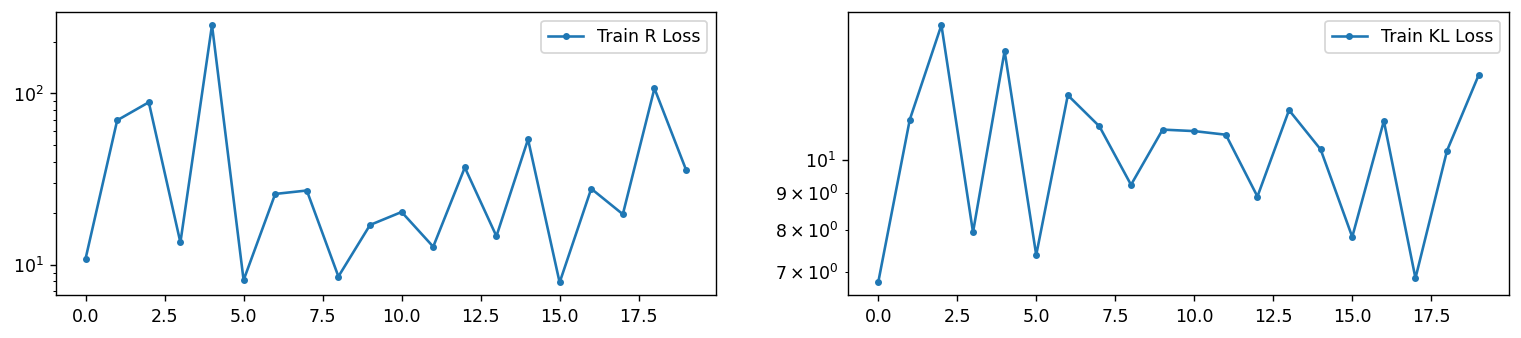

In [178]:
plt.figure(figsize=(15, 3), dpi=125)

plt.subplot(121)
plt.plot(train_loss[:,0], label="Train R Loss", marker="o", ms=3)
# plt.plot(test_loss[:,0], label="Test R Loss")

# plt.ylim(0, 0.1)

plt.legend()
plt.yscale('log')

plt.subplot(122)
plt.plot(train_loss[:,1], label="Train KL Loss", marker="o", ms=3)
# plt.plot(test_loss[:,1], label="Test KL Loss")

# plt.ylim(0, 0.15)

plt.legend()
plt.yscale('log')

(<tf.Tensor: shape=(), dtype=float32, numpy=7.0975313>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.18166876>)